In [1]:
%%html
<style>
    table {
        display: inline-block
    }
</style>

# Black Litterman Asset Allocation Model - N Assets
by Chee-Foong on 18 Dec 2020

## Summary
This analysis extends an earlier analysis done using 2 assets to N asset.  It demostrates how investor's view on implied returns of each assets can be implemented in the asset allocation process.


## Data
| Information Type | Details |
| :- | :- |
| Source | [Kenneth R French Data Library](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html) |
| Risk Free Rate | Treasury Yield 10 Years (^TNX) |
| Assets | 10 Industry Portfolios |
| Date Range | Last 36 months |
| Return Frequency | Monthly |

## Reference
1. https://papers.ssrn.com/sol3/papers.cfm?abstract_id=334304
2. https://faculty.fuqua.duke.edu/~charvey/Teaching/IntesaBci_2001/GS_The_intuition_behind.pdf
4. https://www.stat.berkeley.edu/~nolan/vigre/reports/Black-Litterman.pdf
5. https://www.mit.edu/~dbertsim/papers/Finance/Inverse%20Optimization%20-%20A%20New%20Perspective%20on%20the%20Black-Litterman%20Model.pdf
6. https://projecteuclid.org/download/pdfview_1/euclid.bj/1241444898
7. https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html#

## Import Libraries

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

import sys  
sys.path.append('../src') 
from edge_risk_kit import *

import edge_risk_kit as erk

import ipywidgets as widgets
from IPython.display import display

import ipywidgets as widgets
from IPython.display import display
from ipywidgets import HBox, Label, Box

In [3]:
import numpy as np
import pandas as pd
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

DATA_FOLDER = '../data/'

import urllib
import zipfile

## Import Data

In [4]:
ind30_url = 'http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/30_Industry_Portfolios_CSV.zip'
ind10_url = 'http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/10_Industry_Portfolios_CSV.zip'

zip_path, _ = urllib.request.urlretrieve(ind30_url)
with zipfile.ZipFile(zip_path, "r") as f:
    f.extractall(DATA_FOLDER)   

zip_path, _ = urllib.request.urlretrieve(ind10_url)
with zipfile.ZipFile(zip_path, "r") as f:
    f.extractall(DATA_FOLDER)     

In [5]:
def process_ind_data(filename, tblname):
    ind_data = pd.read_csv(DATA_FOLDER + filename, skiprows=11)
    ind_data.rename(columns={ind_data.columns[0]:'date'}, inplace=True)
    ind_data[ind_data.date.isnull()]
    header_index = ind_data[ind_data.date.isnull()].index.to_list()
    header_index.append(ind_data.index[-1])
    header_index = [0] + header_index
    ind_data['type'] = np.nan
    tbl_name = ['vw_rets_mthly','ew_rets_mthly','vw_rets_annually','ew_rets_annually',
               'no_of_firms','avg_firm_size','be_over_me','vw_avg_beome']

    for i in range(0,len(tbl_name)):
        ind_data.loc[header_index[i]:header_index[i+1], 'type'] = tbl_name[i]

    ind_data.dropna(inplace=True)
    
    out = ind_data[ind_data.type == tblname]
    out.drop('type', axis=1, inplace=True)
    out.date = pd.to_datetime(out.date, format="%Y%m")
    out.set_index('date', inplace=True)
    out.index = out.index.to_period('M')
    
    if tblname == 'vw_rets_mthly':
        out = out.astype(float)
        out = out.div(100)
        
    if tblname == 'no_of_firms':
        out = out.astype(int)

    if tblname == 'avg_firm_size':
        out = out.astype(float)

    return out

In [6]:
vw_rets_mthly_10 = process_ind_data('10_Industry_Portfolios.CSV', 'vw_rets_mthly')
no_of_firms_10 = process_ind_data('10_Industry_Portfolios.CSV', 'no_of_firms')
avg_firm_size_10 = process_ind_data('10_Industry_Portfolios.CSV', 'avg_firm_size')

In [7]:
def get_total_market_index_returns(ind_nfirms, ind_size, ind_return):
    ind_mktcap = ind_nfirms * ind_size
    total_mktcap = ind_mktcap.sum(axis=1)
    ind_capweight = ind_mktcap.divide(total_mktcap, axis="rows")
    total_market_return = (ind_capweight * ind_return).sum(axis="columns")
    return total_market_return

In [8]:
mkt_cap = no_of_firms_10 * avg_firm_size_10

In [9]:
mktcap_wgts = mkt_cap.div(mkt_cap.sum(axis=1), axis=0)
mktcap_wgts.columns = mktcap_wgts.columns.str.strip()
vw_rets_mthly_10.columns = vw_rets_mthly_10.columns.str.strip()

In [10]:
# get_total_market_index_returns(no_of_firms_10, avg_firm_size_10, vw_rets_mthly_10)

---
## Risk Free Rate - 10 Year Treasury Yield

In [11]:
tickers = ['AAPL','^TNX']

start_date = '2016-01-01'
end_date = '2020-12-31'

In [12]:
import yfinance as yf

tickerlist = []

for ticker in tickers:
    tickerinfo = {}
    tickerinfo['ticker'] = ticker
    tickerinfo['name'] = yf.Ticker(ticker).info['shortName']
    tickerinfo['marketCap'] = yf.Ticker(ticker).info['marketCap']
    tickerlist.append(tickerinfo)
    
tickerlist = pd.DataFrame(tickerlist)
tickerlist.set_index('ticker', inplace=True)

In [13]:
data = yf.download(tickers, start=start_date, end=end_date)
prices = data['Adj Close'][tickers].dropna()

[*********************100%***********************]  2 of 2 completed


In [14]:
rfr = prices['^TNX']/100
print('Risk Free Rate: {:.3f}%'.format(rfr[-1]*100))

Risk Free Rate: 0.930%


In [15]:
rfr_monthly = rfr.resample('M').fillna('ffill')
rfr_monthly.index = rfr_monthly.index.to_period('M')
rfr_monthly.tail()

Date
2020-08    0.00693
2020-09    0.00677
2020-10    0.00860
2020-11    0.00844
2020-12    0.00930
Freq: M, Name: ^TNX, dtype: float64

## Sector Returns
- Using only the returns of the past 36 months

In [16]:
rets_monthly = vw_rets_mthly_10.iloc[-36:]
cov_monthly = vw_rets_mthly_10.cov()

Summary

In [17]:
rfr_period = rfr_monthly
rets_period = rets_monthly
PERIODS_PER_YEAR = 12

erk.summary_stats(rets_period, riskfree_rate=rfr_period[-1], 
                  periods_per_year=PERIODS_PER_YEAR).sort_values('Sharpe Ratio', ascending=False) \
            .style.bar(color=['pink', 'lightgreen'], align='zero')

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Shops,0.217886,0.200603,0.196976,3.395476,0.072067,0.088800,1.030992,-0.149376
HiTec,0.222032,0.207624,-0.196011,2.525975,0.082439,0.093000,1.015924,-0.177765
Hlth,0.096188,0.162531,0.053606,3.006418,0.066637,0.086300,0.530029,-0.122595
Durbl,0.209260,0.385028,1.147674,6.096707,0.113435,0.173600,0.514834,-0.283738
Telcm,0.077816,0.164106,-0.867429,3.872452,0.079487,0.111250,0.413924,-0.202457
Utils,0.044798,0.150700,-1.169997,4.259089,0.078020,0.114500,0.233503,-0.216136
Manuf,0.049231,0.203074,-0.860704,3.870658,0.101660,0.134350,0.194889,-0.263178
NoDur,0.025774,0.159359,-0.926606,3.668407,0.082033,0.113600,0.102439,-0.195239
Other,0.028216,0.202839,-1.083343,4.833401,0.105273,0.147650,0.092382,-0.277915
Enrgy,-0.222028,0.366700,-0.074571,6.332100,0.181820,0.249700,-0.625577,-0.609145


## Black Littleman Asset Allocation Model

### Procedures
1. Set the default parameters
2. Calculate the benchmark weights
3. Estimate the covariance matrix
2. Estimate the equilibrium implied returns using benchmark weights and covariance matrix
3. Set the investor's views
4. Estimate the Black-Litterman expected returns and covariance matrix
5. Calculate the optimised weights using maximum sharpe ratio using BL expected returns and convariance matrix

### Market Parameter Inputs

| Parameters | Description | Remarks |
| :- | :- | :- | 
| $w$ | A Column Vector ($N \times 1$) of Equilibrium Market Weights of the Assets | Market Cap Weights of the 2 Assets |
| $\Sigma$ | A Covariance Matrix ($N \times N$) of the Assets | Covariance Matrix of Monthly Returns between 2 Assets |
| $R_f$ | The Risk Free Rate | Latest Treasury Yield 10 Years |
| $\delta$ | The investor's Risk Aversion parameter | Default in this analysis is 2.5.  Alternatively, $\delta = \mu_M/\sigma^2_M$ |
| $\tau$ | A scalar indicating the uncertainty of the prior | Default in this analysis is 0.02.  Alternatively, $\tau = 1/T$ where $T$ is the number of periods of data used. |


### Investor Views Inputs

| Parameters | Description | Remarks |
| :- | :- | :- | 
| $Q$ | An $K \times 1$ 'Qualitative Views' or simply, Views matrix | Absolute views of an asset's expected return vs the market's implied return.  Eg: Expected return of AAPL is 3% instead of market implied return of 2%.  <p><p> Relative views of an asset's expected return vs another asset's expected return. Eg: Expected return of AAPL will overperform TSLA by 2%. |
| $P$ | A $K \times N$ 'Projection' or 'Pick' matrix, linking each view to the assets | If $Q$ is absolute view, $P$ is an identity $N$ x $N$ matrix where N is the number of assets. <p><p> If $Q$ is relative view, $P$ is a $K$ x $N$ matrix where N is the number of assets and K is the number of relative views. -1 marked for the underperforming asset, 1 marked for the overperforming asset and 0 for the rest.|
| $\Omega$ | A Covariance matrix representing the uncertainty of views | The diagonal matrix obtained from the diagonal elements of $P \tau \Sigma P^T$ |


### Implied Expected Returns at Equilibrium 

The implied returns vector $\pi$ from a set of portfolio weights $w$.

$$\pi = \delta\Sigma w$$

$w$ is usually the benchmark weights.  Market cap weights of AAPL and TSLA in our example here.

In [18]:
def implied_returns(delta, sigma, w):
    """
Obtain the implied expected returns by reverse engineering the weights
Inputs:
delta: Risk Aversion Coefficient (scalar)
sigma: Variance-Covariance Matrix (N x N) as DataFrame
    w: Portfolio weights (N x 1) as Series
Returns an N x 1 vector of Returns as Series
    """
    ir = delta * sigma.dot(w).squeeze() # to get a series from a 1-column dataframe
    ir.name = 'Implied Returns'
    return ir


### Omega matrix

The uncertaintly associated with the view in the $\Omega$ matrix, one could make the simplifying assumption that $\Omega$ is proportional to the variance of the benchmark.

$$\Omega = diag(P (\tau \Sigma) P^T) $$

In [19]:
# Assumes that Omega is proportional to the variance of the prior
def proportional_prior(sigma, tau, p):
    """
    Returns the He-Litterman simplified Omega
    Inputs:
    sigma: N x N Covariance Matrix as DataFrame
    tau: a scalar
    p: a K x N DataFrame linking Q and Assets
    returns a P x P DataFrame, a Matrix representing Prior Uncertainties
    """
    helit_omega = p.dot(tau * sigma).dot(p.T)
    # Make a diag matrix from the diag elements of Omega
    return pd.DataFrame(np.diag(np.diag(helit_omega.values)),index=p.index, columns=p.index)

### Black Litterman Formula

The first step of the procedure is a _reverse-optimization_ step that infers the implied returns vector $\pi$ that are implied by the equilibrium weights $w$ using the formula:

$$\pi = \delta\Sigma w$$

Next, the posterior returns and covariances are obtained from the _Black-Litterman Master Formula_ which is the following set of equations:

\begin{equation}
\label{eq:blMu}
\mu^{BL} = \pi + \tau \Sigma P^T[(P \tau \Sigma P^T) + \Omega]^{-1}[Q - P \pi]
\end{equation}

\begin{equation}
\label{eq:blSigma}
\Sigma^{BL} = \Sigma + \tau \Sigma - \tau\Sigma P^T(P \tau \Sigma P^T + \Omega)^{-1} P \tau \Sigma
\end{equation}


In [20]:
from numpy.linalg import inv

def bl(w_prior, sigma_prior, p, q,
                omega=None,
                delta=2.5, tau=.02):
    """
# Computes the posterior expected returns based on 
# the original black litterman reference model
#
# W.prior must be an N x 1 vector of weights, a Series
# Sigma.prior is an N x N covariance matrix, a DataFrame
# P must be a K x N matrix linking Q and the Assets, a DataFrame
# Q must be an K x 1 vector of views, a Series
# Omega must be a K x K matrix a DataFrame, or None
# if Omega is None, we assume it is
#    proportional to variance of the prior
# delta and tau are scalars
    """
    if omega is None:
        omega = proportional_prior(sigma_prior, tau, p)
    # Force w.prior and Q to be column vectors
    # How many assets do we have?
    N = w_prior.shape[0]
    # And how many views?
    K = q.shape[0]
    # First, reverse-engineer the weights to get pi
    pi = implied_returns(delta, sigma_prior,  w_prior)
    # Adjust (scale) Sigma by the uncertainty scaling factor
    sigma_prior_scaled = tau * sigma_prior  
    # posterior estimate of the mean, use the "Master Formula"
    # we use the versions that do not require
    # Omega to be inverted (see previous section)
    # this is easier to read if we use '@' for matrixmult instead of .dot()
    #     mu_bl = pi + sigma_prior_scaled @ p.T @ inv(p @ sigma_prior_scaled @ p.T + omega) @ (q - p @ pi)
    mu_bl = pi + sigma_prior_scaled.dot(p.T).dot(inv(p.dot(sigma_prior_scaled).dot(p.T) + omega).dot(q - p.dot(pi).values))
    # posterior estimate of uncertainty of mu.bl
#     sigma_bl = sigma_prior + sigma_prior_scaled - sigma_prior_scaled @ p.T @ inv(p @ sigma_prior_scaled @ p.T + omega) @ p @ sigma_prior_scaled
    sigma_bl = sigma_prior + sigma_prior_scaled - sigma_prior_scaled.dot(p.T).dot(inv(p.dot(sigma_prior_scaled).dot(p.T) + omega)).dot(p).dot(sigma_prior_scaled)
    return (mu_bl, sigma_bl)

### Asset Allocation using Maximum Sharpe Ratio Portfolio

The Max Sharpe Ratio (MSR) Portfolio weights are easily computed in explicit form if there are no constraints on the weights.
The weights are given by the expression:

$$ W_{MSR} = \frac{\Sigma^{-1}\mu_e}{\bf{1}^T \Sigma^{-1}\mu_e} $$

where $\mu_e$ is the vector of expected excess returns and $\Sigma$ is the variance-covariance matrix.

In [21]:
# for convenience and readability, define the inverse of a dataframe
def inverse(d):
    """
    Invert the dataframe by inverting the underlying matrix
    """
    return pd.DataFrame(inv(d.values), index=d.columns, columns=d.index)

def w_msr(sigma, mu, scale=True):
    """
    Optimal (Tangent/Max Sharpe Ratio) Portfolio weights
    by using the Markowitz Optimization Procedure
    Mu is the vector of Excess expected Returns
    Sigma must be an N x N matrix as a DataFrame and Mu a column vector as a Series
    This implements page 188 Equation 5.2.28 of
    "The econometrics of financial markets" Campbell, Lo and Mackinlay.
    """
    w = inverse(sigma).dot(mu)

    if scale:
        def scale_wgts(w):
            w = w/sum(w) # fix: this assumes all w is +ve
            return w
        
        w = scale_wgts(w)
    return w

---
# N Asset Portfolio Example

## Portfolio Parameters

In [22]:
DELTA = 2.5
TAU = 1/rets_monthly.shape[0]

Note the market cap weighted portfolio has a very large exposure in HiTec and very small exposure in Enrgy.  This is likely due to the run up of technology stocks in recent months.  Energy stocks in the other extreme is valued cheaply due to country lockdowns globally because of coronavirus pandemic.

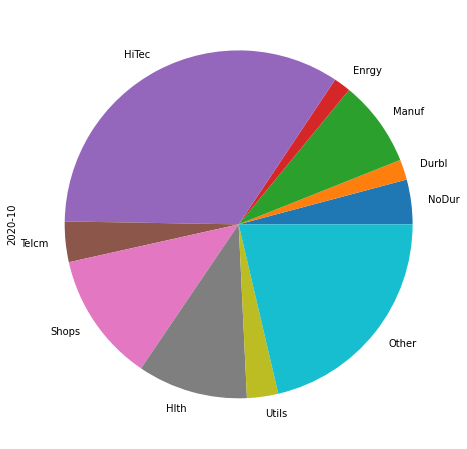

In [23]:
wgts_prior = mktcap_wgts.iloc[-1]
wgts_prior.plot(kind='pie', figsize=(8,8))
plt.show()

In [24]:
cov_monthly

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
NoDur,0.002102,0.002629,0.002419,0.001784,0.002432,0.001444,0.002300,0.002021,0.001778,0.002466
Durbl,0.002629,0.006108,0.004200,0.003005,0.004345,0.002266,0.003601,0.002730,0.002577,0.004006
Manuf,0.002419,0.004200,0.003877,0.002856,0.003867,0.001974,0.003067,0.002619,0.002365,0.003620
Enrgy,0.001784,0.003005,0.002856,0.003945,0.002752,0.001514,0.002149,0.001953,0.002075,0.002782
HiTec,0.002432,0.004345,0.003867,0.002752,0.005193,0.002262,0.003330,0.002878,0.002430,0.003694
Telcm,0.001444,0.002266,0.001974,0.001514,0.002262,0.002114,0.001820,0.001547,0.001586,0.002086
Shops,0.002300,0.003601,0.003067,0.002149,0.003330,0.001820,0.003375,0.002400,0.002062,0.003075
Hlth,0.002021,0.002730,0.002619,0.001953,0.002878,0.001547,0.002400,0.003074,0.001876,0.002623
Utils,0.001778,0.002577,0.002365,0.002075,0.002430,0.001586,0.002062,0.001876,0.003015,0.002522
Other,0.002466,0.004006,0.003620,0.002782,0.003694,0.002086,0.003075,0.002623,0.002522,0.004097


Implied returns given the benchmark wgts (market cap wgts) and covariance matrix.  Note that these values are implied monthly returns.

In [25]:
s = cov_monthly
pi = implied_returns(delta=DELTA, sigma=s, w=wgts_prior)

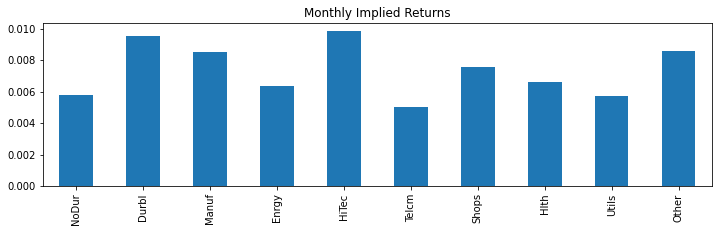

In [26]:
pi.plot(kind='bar', figsize=(12,3), title='Monthly Implied Returns')
plt.show()

Annual Implied Returns

In [27]:
def mthly2ann(x):
    return np.expm1(x*12)

def ann2mthly(x):
    return np.log1p(x)/12

In [28]:
pi_ann = pd.DataFrame(mthly2ann(pi))
pi_ann.T.round(2)

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
Implied Returns,0.07,0.12,0.11,0.08,0.13,0.06,0.09,0.08,0.07,0.11


## Markowitz Procedure
- With the implied returns, the maximum sharpe ratio weights should be the same as the market cap benchmark weights.

In [29]:
tickers = pi.index

mu_exp = pd.Series(pi, index=tickers)
msr_w = np.round(w_msr(s, mu_exp)*100, 2)

Setting a single sector view (with respect to implied benchmark returns).  For example, instead of having an implied return of 12.57%, investor's view is that HiTec will have an implied return of 12.8% annual return.

In [30]:
SECTOR = 'HiTec' ## Set sector of interest
print('Benckmark Monthly Implied Returns: {:.2f}%'.format(pi[SECTOR]*100))
print('Benckmark Annual Implied Returns: {:.2f}%'.format(mthly2ann(pi[SECTOR])*100))

Benckmark Monthly Implied Returns: 0.99%
Benckmark Annual Implied Returns: 12.57%


In [31]:
ann_view = 12.8 ## Annual return of sector view in percentage terms
ann_view = ann_view / 100
mthly_view = ann2mthly(ann_view)
print('Investor\'s View: {}'.format(SECTOR))
print('Annual Implied Return: {:.2f}%'.format(ann_view*100))
print('Monthly Implied Return: {:.2f}%'.format(mthly_view*100))
print('Monthly Implied Return relative to benckmark: {:.2f}%'.format((mthly_view-pi[SECTOR])*100))

Investor's View: HiTec
Annual Implied Return: 12.80%
Monthly Implied Return: 1.00%
Monthly Implied Return relative to benckmark: 0.02%


In [32]:
tickers = pi.index

new_pi = pi.copy()
new_pi[SECTOR] = mthly_view

mu_exp = pd.Series(new_pi, index=tickers)
new_msr_w = np.round(w_msr(s, mu_exp, scale=True)*100, 2)

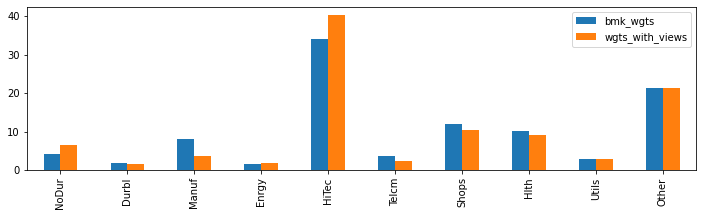

In [33]:
combine = pd.concat([msr_w, new_msr_w], axis=1)
combine.columns = ['bmk_wgts', 'wgts_with_views']
combine.plot(kind='bar', figsize=(12,3))
plt.show()

In [34]:
combine['diff'] = combine.wgts_with_views - combine.bmk_wgts
combine.style.format("{:.2f}").bar(color=['pink', 'lightgreen'], align='zero')

,bmk_wgts,wgts_with_views,diff
NoDur,4.15,6.47,2.32
Durbl,1.89,1.63,-0.26
Manuf,8.02,3.65,-4.37
Enrgy,1.59,1.86,0.27
HiTec,34.09,40.35,6.26
Telcm,3.76,2.41,-1.35
Shops,12.03,10.36,-1.67
Hlth,10.24,9.00,-1.24
Utils,2.90,2.94,0.04
Other,21.34,21.34,0.00


Using naive Markowitz procedure, noticed that drastic and impractical changes in portfolio weights when there is only a slight change in implied return expectation.

## Black Litterman Asset Allocation Model
### Absolute View

Annualised Benchmark Implied Returns

In [35]:
mthly2ann(pi)

NoDur    0.071559
Durbl    0.121343
Manuf    0.107598
Enrgy    0.078846
HiTec    0.125676
Telcm    0.061970
Shops    0.094651
Hlth     0.082204
Utils    0.071399
Other    0.108576
Name: Implied Returns, dtype: float64

Set investor's views for specific sectors.  Specific expected returns of industries that deviate from the benchmark.  Assume similarly, investor's view is that HiTec will have an implied return of 12.8% annual return.

In [36]:
tickers = pi.index
views = pi.copy()

In [37]:
ann_view = 12.8 ## Annual return of sector view in percentage terms
ann_view = ann_view / 100
mthly_view = ann2mthly(ann_view)
views['HiTec'] = mthly_view

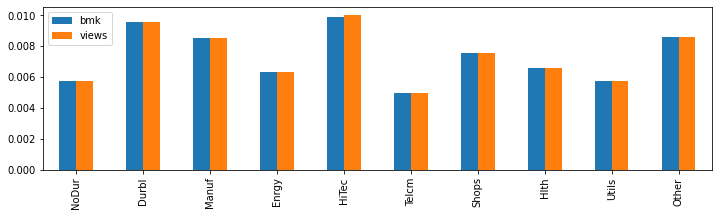

In [38]:
combine = pd.concat([pi, views], axis=1)
combine.columns = ['bmk','views']
combine.plot(kind='bar', figsize=(12,3))
plt.show()

Note only a slight change in implied return for HiTec Sector.

In [39]:
combine['diff'] = combine.bmk - combine.views
combine.style.format("{:.4f}").bar(color=['pink', 'lightgreen'], align='zero')

,bmk,views,diff
NoDur,0.0058,0.0058,0.0000
Durbl,0.0095,0.0095,0.0000
Manuf,0.0085,0.0085,0.0000
Enrgy,0.0063,0.0063,0.0000
HiTec,0.0099,0.0100,-0.0002
Telcm,0.0050,0.0050,0.0000
Shops,0.0075,0.0075,0.0000
Hlth,0.0066,0.0066,0.0000
Utils,0.0057,0.0057,0.0000
Other,0.0086,0.0086,0.0000


Applying the Black-Litterman Procedure.  Note the Black-Litterman implied returns.

In [40]:
q = views
p = pd.DataFrame(np.identity(len(q)).astype(int), columns=tickers)

In [41]:
# Find the Black Litterman Expected Returns
bl_mu, bl_sigma = bl(w_prior=wgts_prior, sigma_prior=s, p=p, q=q, tau=TAU, delta=DELTA)

# Black Litterman Implied Mu
combine = pd.concat([pi, views, bl_mu], axis=1)
combine.columns = ['bmk', 'views', 'bl_views']
combine['diff'] = combine.bl_views - combine.bmk
combine.style.format("{:.5f}").bar(color=['pink', 'lightgreen'], align='zero')

,bmk,views,bl_views,diff
NoDur,0.00576,0.00576,0.00576,0.00000
Durbl,0.00954,0.00954,0.00956,0.00002
Manuf,0.00852,0.00852,0.00853,0.00002
Enrgy,0.00632,0.00632,0.00633,0.00001
HiTec,0.00987,0.01004,0.00991,0.00005
Telcm,0.00501,0.00501,0.00502,0.00001
Shops,0.00754,0.00754,0.00755,0.00001
Hlth,0.00658,0.00658,0.00659,0.00001
Utils,0.00575,0.00575,0.00575,0.00000
Other,0.00859,0.00859,0.00860,0.00001


Comparing the asset allocation of 
1. benchmark equilibrium (market cap)
2. Markowitz procedure
3. Black-Litterman procedure

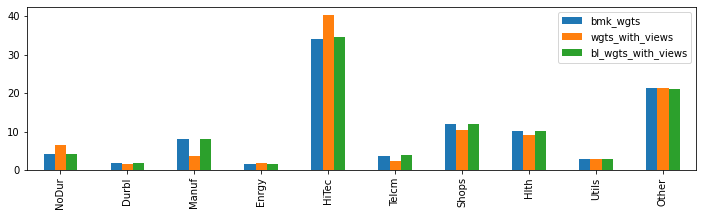

In [42]:
# Use the Black Litterman expected returns to get the Optimal Markowitz weights
bl_w_msr = np.round(w_msr(bl_sigma, bl_mu)*100, 2)

# Using Markowitz 
new_msr_w = np.round(w_msr(s, views)*100, 2)

combine = pd.concat([msr_w, new_msr_w, bl_w_msr], axis=1)
combine.columns = ['bmk_wgts', 'wgts_with_views', 'bl_wgts_with_views']
combine.plot(kind='bar', figsize=(12,3))
plt.show()

Observe that a slight change in expected return for one sector will cause significant changes on the portfolio weights when using the naive markowitz procedure.  On the other hand, the Black-Litterman procedure is more stable and practical.

---
## Relative View
The Black-Litterman Asset Allocation procedure also allows for investor's view of an asset being relative to other assets.  More than one relative views can be added.  Observe how the asset allocation of the portfolio changes when more views are added.

### View 1: HiTec to overperform Enrgy by 5%

In [43]:
print('Benchmark Annual Relative View: {:.2f}%'.format((mthly2ann(pi)['HiTec'] - mthly2ann(pi)['Enrgy'])*100))

Benchmark Annual Relative View: 4.68%


In [44]:
view1 = 5 ## Annual relative return
view1 = view1 / 100
view1 = ann2mthly(view1)
q1 = pd.Series([view1])

In [45]:
# start with a single view, all zeros and overwrite the specific view
p1 = pd.DataFrame([0.]*len(tickers), index=tickers)

In [46]:
p1.loc['Enrgy'] = -1
p1.loc['HiTec'] = 1
p1 = p1.T

p = p1.copy()
q = q1.copy()

#### Omega adjustment to reflect certainty of the view

In [47]:
certainty = [1]

# This is the default "Proportional to Prior" assumption
omega = proportional_prior(s, TAU, p)

for k, c in enumerate(certainty):
    omega.iloc[k,k] = c * omega.iloc[k,k]

In [48]:
# Find the Black Litterman Expected Returns
bl_mu, bl_sigma = bl(w_prior=wgts_prior, sigma_prior=s, p=p, q=q, tau=TAU, delta = DELTA, omega=omega)

# Use the Black Litterman expected returns to get the Optimal Markowitz weights
bl_w_msr = np.round(w_msr(bl_sigma, bl_mu)*100, 2)

combine = pd.concat([msr_w, bl_w_msr], axis=1)
combine.columns = ['bmk', 'bl_views']
combine['diff'] = combine.bl_views - combine.bmk
combine.style.format("{:.5f}").bar(color=['pink', 'lightgreen'], align='zero')

,bmk,bl_views,diff
NoDur,4.15000,4.15000,0.00000
Durbl,1.89000,1.89000,0.00000
Manuf,8.02000,8.02000,0.00000
Enrgy,1.59000,-1.87000,-3.46000
HiTec,34.09000,37.55000,3.46000
Telcm,3.76000,3.76000,0.00000
Shops,12.03000,12.03000,0.00000
Hlth,10.24000,10.24000,0.00000
Utils,2.90000,2.90000,0.00000
Other,21.34000,21.34000,0.00000


#### Observations
1. Only the weights of the sectors in which the investor has an view on are affected.
2. Negative weights in Enrgy sector refer to short Enrgy sector to buy HiTec sector to reflect investor's view on being bullish on HiTec sector over Enrgy sector.

### View 2: Durbl to outperform NoDur and Telcm by 3%

Annualised Benchmark Implied Returns

In [49]:
mthly2ann(pi)

NoDur    0.071559
Durbl    0.121343
Manuf    0.107598
Enrgy    0.078846
HiTec    0.125676
Telcm    0.061970
Shops    0.094651
Hlth     0.082204
Utils    0.071399
Other    0.108576
Name: Implied Returns, dtype: float64

In [50]:
view2 = 6 ## Annual relative return in percentage terms
view2 = view2 / 100
view2 = ann2mthly(view2)
q2 = pd.Series([view2])

In [51]:
def re_weight(bmk, namelist):
    return bmk.loc[namelist]/bmk.loc[namelist].sum()

In [52]:
# start with a single view, all zeros and overwrite the specific view
p2 = pd.DataFrame([0.]*len(tickers), index=tickers)

Assign the weights of the view based on weight of the sectors in the benchmark.

In [53]:
p2.loc['Durbl'] = 1
p2.loc['NoDur'] = -re_weight(wgts_prior, ['NoDur','Telcm'])['NoDur']
p2.loc['Telcm'] = -re_weight(wgts_prior, ['NoDur','Telcm'])['Telcm']
p2 = p2.T

In [54]:
p = pd.concat([p1,p2]).reset_index(drop=True)
q = pd.concat([q1,q2]).reset_index(drop=True)

Summary of Investor's View
- p shows the weighting of each view
- q shows the relative implied returns in absolute terms

In [55]:
p

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
0,0.000000,0.0,0.0,-1.0,1.0,0.000000,0.0,0.0,0.0,0.0
1,-0.524389,1.0,0.0,0.0,0.0,-0.475611,0.0,0.0,0.0,0.0


In [56]:
q

0    0.004066
1    0.004856
dtype: float64

#### Omega adjustment to reflect certainty of the view
Note the certainty includes that for view 1 and view 2

In [57]:
certainty = [1, 1.5]

# This is the default "Proportional to Prior" assumption
omega = proportional_prior(s, TAU, p)

for k, c in enumerate(certainty):
    omega.iloc[k,k] = c * omega.iloc[k,k]

In [58]:
# Find the Black Litterman Expected Returns
bl_mu, bl_sigma = bl(w_prior=wgts_prior, sigma_prior=s, p=p, q=q, tau=TAU, delta = DELTA, omega=omega)

# Use the Black Litterman expected returns to get the Optimal Markowitz weights
bl_w_msr = np.round(w_msr(bl_sigma, bl_mu)*100, 2)

combine = pd.concat([msr_w, bl_w_msr], axis=1)
combine.columns = ['bmk', 'bl_views']
combine['diff'] = combine.bl_views - combine.bmk
combine.style.format("{:.5f}").bar(color=['pink', 'lightgreen'], align='zero')

,bmk,bl_views,diff
NoDur,4.15000,1.93000,-2.22000
Durbl,1.89000,6.13000,4.24000
Manuf,8.02000,8.02000,0.00000
Enrgy,1.59000,-1.50000,-3.09000
HiTec,34.09000,37.18000,3.09000
Telcm,3.76000,1.75000,-2.01000
Shops,12.03000,12.03000,0.00000
Hlth,10.24000,10.24000,0.00000
Utils,2.90000,2.90000,0.00000
Other,21.34000,21.34000,0.00000


#### Observations
1. Only the weights of the sectors in which the investor has views on are affected.
2. Slight changes to those sectors allocation due to view 1.  This is because of the covariance matrix which will make adjustment to the implied returns of sectors due to view 1 when investor has additional views.

### View 3: Shops and Hlth to outperform Utils by 1%

In [59]:
mthly2ann(pi)

NoDur    0.071559
Durbl    0.121343
Manuf    0.107598
Enrgy    0.078846
HiTec    0.125676
Telcm    0.061970
Shops    0.094651
Hlth     0.082204
Utils    0.071399
Other    0.108576
Name: Implied Returns, dtype: float64

In [60]:
view3 = 1 ## Annual relative return in percentage terms
view3 = view3 / 100
view3 = ann2mthly(view3)
q3 = pd.Series([view3])

In [61]:
# start with a single view, all zeros and overwrite the specific view
p3 = pd.DataFrame([0.]*len(tickers), index=tickers)

Assign the weights of the view based on weight of the sectors in the benchmark.

In [62]:
p3.loc['Utils'] = -1
p3.loc['Shops'] = re_weight(wgts_prior, ['Shops','Hlth'])['Shops']
p3.loc['Hlth'] = re_weight(wgts_prior, ['Shops','Hlth'])['Hlth']
p3 = p3.T

In [63]:
p = pd.concat([p1,p2,p3]).reset_index(drop=True)
q = pd.concat([q1,q2,q3]).reset_index(drop=True)

Summary of Investor's View
- p shows the weighting of each view
- q shows the relative implied returns in absolute terms

In [64]:
p

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
0,0.000000,0.0,0.0,-1.0,1.0,0.000000,0.000000,0.000000,0.0,0.0
1,-0.524389,1.0,0.0,0.0,0.0,-0.475611,0.000000,0.000000,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.000000,0.540252,0.459748,-1.0,0.0


In [65]:
q

0    0.004066
1    0.004856
2    0.000829
dtype: float64

In [66]:
certainty = [1, 1.5, 0.5]

# This is the default "Proportional to Prior" assumption
omega = proportional_prior(s, TAU, p)

for k, c in enumerate(certainty):
    omega.iloc[k,k] = c * omega.iloc[k,k]

In [67]:
# Find the Black Litterman Expected Returns
bl_mu, bl_sigma = bl(w_prior=wgts_prior, sigma_prior=s, p=p, q=q, tau=TAU, delta = DELTA, omega=omega)

# Use the Black Litterman expected returns to get the Optimal Markowitz weights
bl_w_msr = np.round(w_msr(bl_sigma, bl_mu)*100, 2)

combine = pd.concat([msr_w, bl_w_msr], axis=1)
combine.columns = ['bmk', 'bl_views']
combine['diff'] = combine.bl_views - combine.bmk
combine.style.format("{:.5f}").bar(color=['pink', 'lightgreen'], align='zero')

,bmk,bl_views,diff
NoDur,4.15000,1.75000,-2.40000
Durbl,1.89000,6.47000,4.58000
Manuf,8.02000,8.02000,0.00000
Enrgy,1.59000,-2.29000,-3.88000
HiTec,34.09000,37.97000,3.88000
Telcm,3.76000,1.58000,-2.18000
Shops,12.03000,7.42000,-4.61000
Hlth,10.24000,6.31000,-3.93000
Utils,2.90000,11.43000,8.53000
Other,21.34000,21.34000,0.00000


#### Observations
1. Only the weights of the sectors in which the investor has views on are affected.
2. Adjustment to sector allocation is not drastic when additional views are included.  The Black-Litterman Asset Allocation procedure allows investors to make short term views, rebalance or reallocate according to market developments on near term basis.